<a href="https://www.kaggle.com/code/shreyasdomde/selfdriving?scriptVersionId=164114154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import cv2
import pandas as pd
import numpy as np
import os

from PIL import Image
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import torchvision

2024-02-24 11:54:01.871586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:54:01.871686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:54:02.010901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/self-driving-dataset/train'
test_dir = '/kaggle/input/self-driving-dataset/test'
valid_dir = '/kaggle/input/self-driving-dataset/valid'

In [3]:
for i in os.listdir(valid_dir):
    if i.endswith('csv'):
        valid_df = pd.read_csv(os.path.join(valid_dir, i))
        break
for i in os.listdir(test_dir):
    if i.endswith('csv'):
        test_df = pd.read_csv(os.path.join(test_dir, i))
        break
for i in os.listdir(train_dir):
    if i.endswith('csv'):
        train_df = pd.read_csv(os.path.join(train_dir, i))
        break

# Exploring Dataset

In [4]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images_jpg.rf.88e894868584b7162339704c5ffca791...,259,194,Dog,0,67,110,194
1,images_jpg.rf.88e894868584b7162339704c5ffca791...,259,194,Dog,85,55,205,194
2,S6-contact-peugeot-tweet-125-le-premium-access...,400,235,Motorcycle,66,90,128,230
3,IMG_2903_jpg.rf.89009e38071e979e4b209e2a72e5c7...,1280,1280,Bus,0,603,659,1208
4,poteau-ligne-3_jpg.rf.89056e83f7c199b88834f6fd...,750,1000,Electric pole,383,168,511,817


In [5]:
classes = list(train_df['class'].unique())
class_dict = {cls:i for i, cls in enumerate(classes)}

In [6]:
train_df['class'] = train_df['class'].replace(class_dict)

/tmp/ipykernel_28/2720890252.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['class'] = train_df['class'].replace(class_dict)


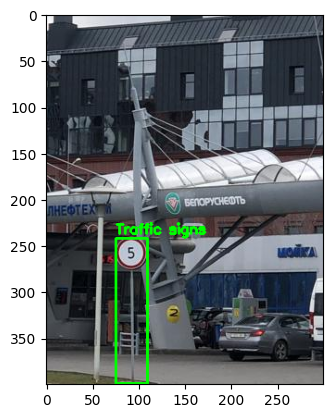

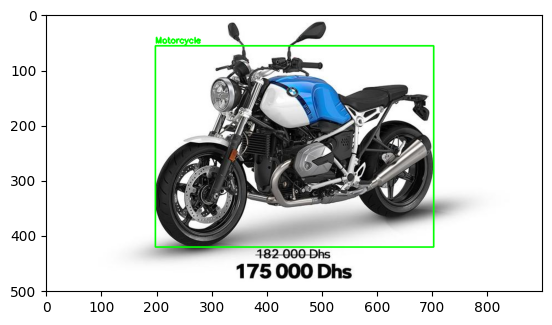

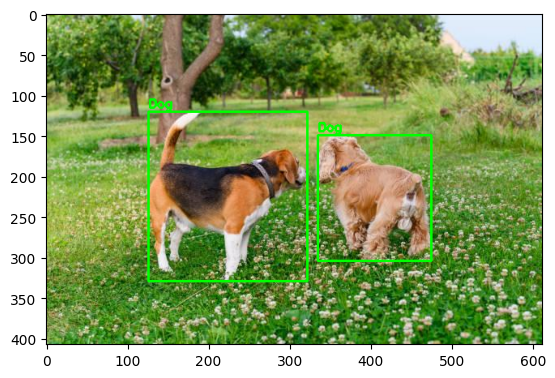

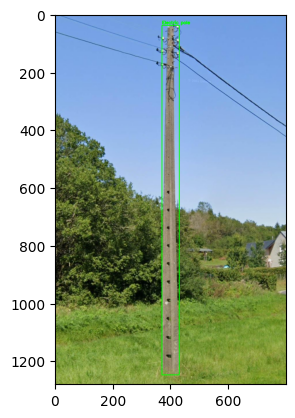

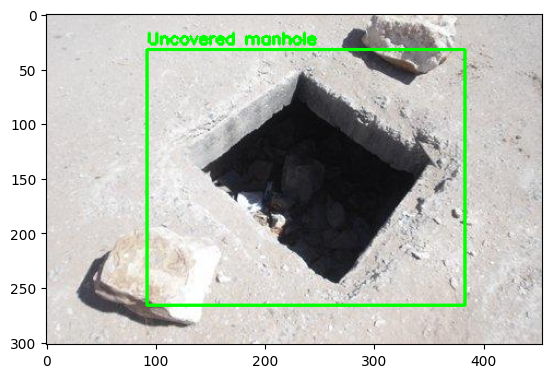

In [7]:
def bounding_box(img_name):
    img = cv2.imread(os.path.join(train_dir, img_name))
    df = train_df[train_df['filename'] == img_name]
    for index, row in df.iterrows():
        xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        for key, value in class_dict.items():
            if row['class'] == value:
                label = key
        cv2.putText(img, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img

for img_name in os.listdir(train_dir)[100:105]:
    img = bounding_box(img_name)
    plt.imshow(img[:, :, ::-1])
    plt.show()

# CREATING INPUTS

In [8]:
inp_data = train_df[['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']]

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]


In [10]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(